In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm

# -----------------------
# Hyperparameters
# -----------------------
EMBED_DIM = 64
BATCH_SIZE = 8
LR = 3e-4
EPOCHS = 100
REG_LAMBDA = 3e-2
PATIENCE = 5  # Early stopping patience
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

# -----------------------
# Data Loading
# -----------------------
train_df = pd.read_csv("../data/train.csv")

unique_users = train_df.user_id.unique()
unique_books = train_df.book_id.unique()

user2idx = {u: i for i, u in enumerate(unique_users)}
book2idx = {b: i for i, b in enumerate(unique_books)}

train_df["user_idx"] = train_df["user_id"].map(user2idx)
train_df["book_idx"] = train_df["book_id"].map(book2idx)

n_users = len(user2idx)
n_books = len(book2idx)

y = train_df["rating"].values
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
train_idx, val_idx = next(splitter.split(train_df, y))

train_data = train_df.iloc[train_idx].reset_index(drop=True)
val_data = train_df.iloc[val_idx].reset_index(drop=True)


class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = df["user_idx"].values
        self.books = df["book_idx"].values
        self.ratings = df["rating"].values.astype(np.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.users[idx], dtype=torch.long),
            torch.tensor(self.books[idx], dtype=torch.long),
            torch.tensor(self.ratings[idx], dtype=torch.float32),
        )


train_dataset = RatingsDataset(train_data)
val_dataset = RatingsDataset(val_data)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

# -----------------------
# Fixed Offset based on User Counts
# -----------------------
user_counts = (
    train_data.groupby("user_idx").size().reindex(range(n_users), fill_value=0).values
)
max_count = user_counts.max()

Using device: mps


In [2]:
fallback_enabled = True
user_id_counts = train_data.groupby("user_id")["user_id"].transform("size")
count2mean = train_data.groupby(user_id_counts)["rating"].mean()
count2mean_dict = count2mean.to_dict()

offset_high = 3.95
offset_low = 2.10

N = 5
half_window = (N - 1) // 2


# We can use a simple weighting scheme. For example, weights that decrease linearly with distance from c:
# weight(distance) = 1 / (1 + distance)
# Alternatively, a Gaussian kernel could be used. Here we use a simple inverse distance approach.
def weight_func(dist):
    return 1.0 / (1.0 + dist)


offsets = np.zeros_like(user_counts, dtype=np.float32)
for i, c in enumerate(user_counts):
    if c < 3:
        # If user has less than 3 reviews, use exact mean for that user
        offsets[i] = count2mean_dict.get(c, 3.95)
        continue
    # Gather means from [c - half_window, c + half_window]
    start = max(c - half_window, 1)
    end = c + half_window

    sum_weighted = 0.0
    sum_weights = 0.0

    for cc in range(start, end + 1):
        if cc in count2mean_dict:
            dist = abs(cc - c)
            w = weight_func(dist)
            sum_weighted += count2mean_dict[cc] * w
            sum_weights += w

    if sum_weights > 0:
        # Compute the smoothed mean
        mean_for_c = sum_weighted / sum_weights
        offsets[i] = mean_for_c
    else:
        # Fallback to old interpolation if we cannot find any counts in the window
        if fallback_enabled:
            f_u = np.log1p(c) / (np.log1p(max_count) if max_count > 0 else 1.0)
            offsets[i] = offset_high + (offset_low - offset_high) * f_u
        else:
            # If no fallback, just use global_mean as baseline offset (0)
            offsets[i] = 0.0

offsets_tensor = torch.tensor(offsets, dtype=torch.float32, device=DEVICE)

In [4]:
# -----------------------
# Model Definition
# -----------------------
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64):
        super(MatrixFactorization, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

        self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, user_ids, item_ids, user_offsets):
        U = self.user_emb(user_ids)
        V = self.item_emb(item_ids)
        u_b = self.user_bias(user_ids).squeeze()
        i_b = self.item_bias(item_ids).squeeze()

        # Add the fixed offset from user_counts
        offset = user_offsets[user_ids]

        pred = (U * V).sum(dim=1) + u_b + i_b + self.global_bias + offset
        return pred


def loss_fn(pred, target, model, reg_lambda):
    mse_loss = nn.MSELoss()(pred, target)
    # L2 regularization on embeddings
    user_reg = model.user_emb.weight.norm(2)
    item_reg = model.item_emb.weight.norm(2)
    return mse_loss + reg_lambda * (user_reg + item_reg)


model = MatrixFactorization(n_users, n_books, EMBED_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

best_val_loss = float("inf")
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for param_group in optimizer.param_groups:
        print("Current learning rate: ", param_group["lr"])
    for users, items, ratings in tqdm(train_loader, total=len(train_loader)):
        users = users.to(DEVICE)
        items = items.to(DEVICE)
        ratings = ratings.to(DEVICE)

        optimizer.zero_grad()
        preds = model(users, items, offsets_tensor)
        loss = loss_fn(preds, ratings, model, REG_LAMBDA)
        loss.backward()
        # Optionally add gradient clipping if needed:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for users, items, ratings in val_loader:
            users = users.to(DEVICE)
            items = items.to(DEVICE)
            ratings = ratings.to(DEVICE)

            preds = model(users, items, offsets_tensor)
            val_loss = nn.MSELoss()(preds, ratings)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    rmse_train = np.sqrt(avg_train_loss)
    rmse_val = np.sqrt(avg_val_loss)
    print(
        f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
    )
    print(f"RMSE Train: {rmse_train:.4f}, RMSE Val: {rmse_val:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model_fixed_offset.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered due to no improvement in validation loss.")
            break

# Load best model
model.load_state_dict(torch.load("best_model_fixed_offset.pt"))

# -----------------------
# Test Prediction
# -----------------------
test_df = pd.read_csv("../data/test.csv")
test_df["user_idx"] = test_df["user_id"].map(user2idx)
test_df["book_idx"] = test_df["book_id"].map(book2idx)

# Handle unknown users/items gracefully:
# If unknown user, assign user_idx as a known baseline user or just clamp offset
test_df["user_idx"] = test_df["user_idx"].apply(
    lambda x: x if x in range(n_users) else n_users - 1
)
test_df["book_idx"] = test_df["book_idx"].apply(
    lambda x: x if x in range(n_books) else n_books - 1
)

test_df["user_idx"] = test_df["user_idx"].fillna(n_users - 1).astype(int)
test_df["book_idx"] = test_df["book_idx"].fillna(n_books - 1).astype(int)

model.eval()
test_users = torch.tensor(test_df["user_idx"].values, dtype=torch.long).to(DEVICE)
test_items = torch.tensor(test_df["book_idx"].values, dtype=torch.long).to(DEVICE)

with torch.no_grad():
    test_preds = model(test_users, test_items, offsets_tensor).cpu().numpy()

test_preds = np.clip(test_preds, 1.0, 5.0)
submission = pd.DataFrame({"id": test_df["id"], "rating": test_preds})
submission.to_csv("submission.csv", index=False)
print("Created submission.csv")

/Users/saidgurbuz/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:58<00:00, 192.81it/s]


Epoch 1/100, Train Loss: 0.7846, Val Loss: 0.7936
RMSE Train: 0.8858, RMSE Val: 0.8908
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:57<00:00, 196.47it/s]


Epoch 2/100, Train Loss: 0.7324, Val Loss: 0.7650
RMSE Train: 0.8558, RMSE Val: 0.8746
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:57<00:00, 195.93it/s]


Epoch 3/100, Train Loss: 0.6928, Val Loss: 0.7431
RMSE Train: 0.8323, RMSE Val: 0.8620
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:59<00:00, 191.09it/s]


Epoch 4/100, Train Loss: 0.6616, Val Loss: 0.7287
RMSE Train: 0.8134, RMSE Val: 0.8537
Current learning rate:  0.0003


100%|██████████| 11309/11309 [01:00<00:00, 188.07it/s]


Epoch 5/100, Train Loss: 0.6365, Val Loss: 0.7165
RMSE Train: 0.7978, RMSE Val: 0.8465
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:59<00:00, 188.84it/s]


Epoch 6/100, Train Loss: 0.6158, Val Loss: 0.7070
RMSE Train: 0.7847, RMSE Val: 0.8408
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:59<00:00, 190.00it/s]


Epoch 7/100, Train Loss: 0.5986, Val Loss: 0.7000
RMSE Train: 0.7737, RMSE Val: 0.8367
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:57<00:00, 195.56it/s]


Epoch 8/100, Train Loss: 0.5839, Val Loss: 0.6949
RMSE Train: 0.7641, RMSE Val: 0.8336
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:57<00:00, 195.16it/s]


Epoch 9/100, Train Loss: 0.5711, Val Loss: 0.6907
RMSE Train: 0.7557, RMSE Val: 0.8311
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:58<00:00, 194.73it/s]


Epoch 10/100, Train Loss: 0.5599, Val Loss: 0.6864
RMSE Train: 0.7482, RMSE Val: 0.8285
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:58<00:00, 194.39it/s]


Epoch 11/100, Train Loss: 0.5499, Val Loss: 0.6846
RMSE Train: 0.7416, RMSE Val: 0.8274
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:59<00:00, 189.28it/s]


Epoch 12/100, Train Loss: 0.5409, Val Loss: 0.6822
RMSE Train: 0.7355, RMSE Val: 0.8260
Current learning rate:  0.0003


100%|██████████| 11309/11309 [01:00<00:00, 187.23it/s]


Epoch 13/100, Train Loss: 0.5329, Val Loss: 0.6811
RMSE Train: 0.7300, RMSE Val: 0.8253
Current learning rate:  0.0003


100%|██████████| 11309/11309 [01:00<00:00, 186.60it/s]


Epoch 14/100, Train Loss: 0.5256, Val Loss: 0.6790
RMSE Train: 0.7250, RMSE Val: 0.8240
Current learning rate:  0.0003


100%|██████████| 11309/11309 [01:00<00:00, 188.19it/s]


Epoch 15/100, Train Loss: 0.5188, Val Loss: 0.6790
RMSE Train: 0.7203, RMSE Val: 0.8240
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:59<00:00, 191.08it/s]


Epoch 16/100, Train Loss: 0.5126, Val Loss: 0.6783
RMSE Train: 0.7160, RMSE Val: 0.8236
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:59<00:00, 190.70it/s]


Epoch 17/100, Train Loss: 0.5069, Val Loss: 0.6782
RMSE Train: 0.7120, RMSE Val: 0.8235
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:59<00:00, 190.97it/s]


Epoch 18/100, Train Loss: 0.5016, Val Loss: 0.6770
RMSE Train: 0.7083, RMSE Val: 0.8228
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:59<00:00, 190.57it/s]


Epoch 19/100, Train Loss: 0.4968, Val Loss: 0.6770
RMSE Train: 0.7048, RMSE Val: 0.8228
Current learning rate:  0.0003


100%|██████████| 11309/11309 [01:00<00:00, 185.87it/s]


Epoch 20/100, Train Loss: 0.4921, Val Loss: 0.6779
RMSE Train: 0.7015, RMSE Val: 0.8233
Current learning rate:  0.0003


100%|██████████| 11309/11309 [00:59<00:00, 191.62it/s]


Epoch 21/100, Train Loss: 0.4878, Val Loss: 0.6771
RMSE Train: 0.6984, RMSE Val: 0.8228
Current learning rate:  0.00015


100%|██████████| 11309/11309 [00:58<00:00, 193.24it/s]


Epoch 22/100, Train Loss: 0.4809, Val Loss: 0.6774
RMSE Train: 0.6934, RMSE Val: 0.8231
Current learning rate:  0.00015


100%|██████████| 11309/11309 [00:58<00:00, 194.03it/s]


Epoch 23/100, Train Loss: 0.4789, Val Loss: 0.6779
RMSE Train: 0.6920, RMSE Val: 0.8234
Current learning rate:  0.00015


100%|██████████| 11309/11309 [00:58<00:00, 193.17it/s]


Epoch 24/100, Train Loss: 0.4770, Val Loss: 0.6775
RMSE Train: 0.6906, RMSE Val: 0.8231
Early stopping triggered due to no improvement in validation loss.
Created submission.csv


/var/folders/3w/x7g6gh3s1y1gry1przjtc12c0000gn/T/ipykernel_28324/1117068810.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mode

<Axes: >

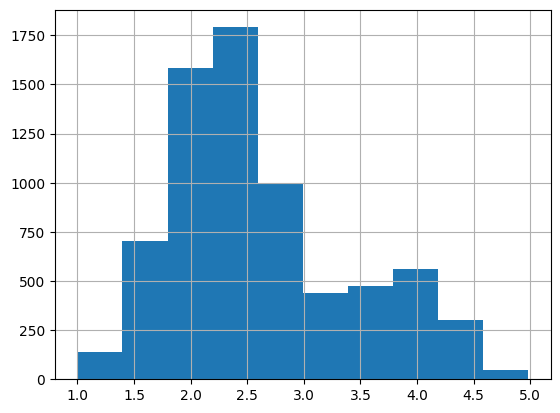

In [5]:
test_df["rating"] = test_preds
user_counts = train_df["user_id"].value_counts()
users_with_less_than_5_reviews = user_counts[user_counts < 8].index

# get the test_df rows with user_ids in users_with_less_than_5_reviews
test_df_filtered = test_df[test_df["user_id"].isin(users_with_less_than_5_reviews)]

# plot the ratings on hist
test_df_filtered["rating"].hist()

In [6]:
train_df["rating"].value_counts()

rating
2.0    21973
1.0    17689
1.5    15399
2.5    14177
3.0     9863
3.5     8167
4.0     6753
5.0     5577
4.5      925
Name: count, dtype: int64

<Axes: >

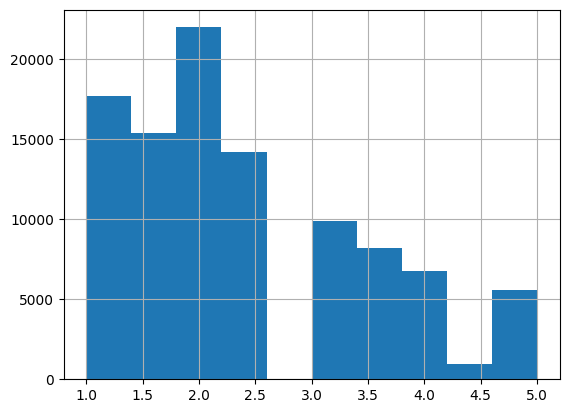

In [7]:
train_df["rating"].hist()

<Axes: >

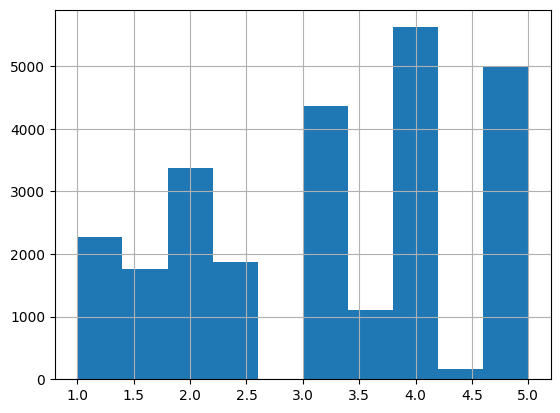

In [8]:
# plot the rating hist in train_df for only the users with less than X (X will be adjustable) reviews
train_df[train_df["user_id"].isin(user_counts[user_counts < 7].index)]["rating"].hist()

In [9]:
user_id_counts[user_id_counts < 7]

6        6
7        3
9        6
16       1
19       6
        ..
90456    3
90459    1
90463    1
90465    1
90469    2
Name: user_id, Length: 25170, dtype: int64

In [10]:
user_id_counts = train_data.groupby("user_id")["user_id"].transform("size")
count2mean = train_data.groupby(user_id_counts)["rating"].mean()
count2mean.head(10)

user_id
1     3.909283
2     3.776454
3     2.691737
4     2.150903
5     2.165625
6     2.188201
7     2.213869
8     2.202817
9     2.119596
10    2.134821
Name: rating, dtype: float64

In [11]:
train_user_counts = train_df["user_id"].value_counts()
# get the avg rating for each user and add it as column to the train_user_counts
train_user_counts = train_user_counts.to_frame().reset_index()
train_user_counts.columns = ["user_id", "count"]
train_user_counts["avg_rating"] = train_df.groupby("user_id")["rating"].mean().values
train_user_counts.head(50)

,user_id,count,avg_rating
0,3785,2041,1.409091
1,28251,524,1.800000
2,43652,350,1.428571
3,5180,345,2.500000
4,27445,266,2.681818
5,32734,263,1.000000
6,30022,236,1.833333
7,35368,203,3.333333
8,44828,203,1.687500
9,10717,201,2.125000


<Axes: >

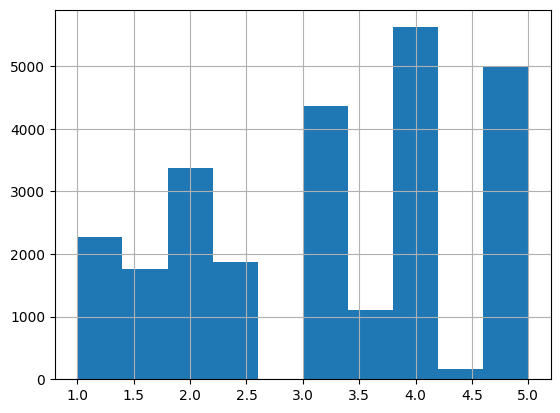

In [12]:
# print get the filtered train_df that only contains the users with less than 5 reviews
user_counts = train_df["user_id"].value_counts()
users_with_less_than_5_reviews = user_counts[user_counts < 7].index
train_df_filtered = train_df[train_df["user_id"].isin(users_with_less_than_5_reviews)]
train_df_filtered["rating"].hist()

In [13]:
# create a train_df_avg_rating_by_user_count that contains the avg rating for each user count
user_id_counts = train_df.groupby("user_id")["user_id"].transform("size")
count2mean = train_df.groupby(user_id_counts)["rating"].mean()
count2mean_dict = count2mean.to_dict()
count2mean_dict

{1: 3.910843051722603,
 2: 3.9035714285714285,
 3: 2.9459582198001817,
 4: 2.2192708333333333,
 5: 2.1670850767085077,
 6: 2.174944071588367,
 7: 2.1969583644976316,
 8: 2.1988357843137254,
 9: 2.168769716088328,
 10: 2.1346938775510202,
 11: 2.073515769944341,
 12: 2.090990990990991,
 13: 2.158480074142725,
 14: 2.0308807733619765,
 15: 2.0517333333333334,
 16: 2.0907738095238093,
 17: 2.0932486631016043,
 18: 2.030583613916947,
 19: 1.9805335255948089,
 20: 2.0349315068493152,
 21: 2.0597326649958227,
 22: 2.1066115702479338,
 23: 2.0855689176688252,
 24: 2.0527482269503547,
 25: 2.091891891891892,
 26: 2.0788084464555054,
 27: 2.0443583118001722,
 28: 2.089923469387755,
 29: 2.1117908787541713,
 30: 1.9,
 31: 2.0683870967741935,
 32: 2.0747767857142856,
 33: 2.033459595959596,
 34: 2.1400560224089635,
 35: 2.0551020408163265,
 36: 2.154589371980676,
 37: 1.9282744282744282,
 38: 1.9312865497076024,
 39: 2.082532051282051,
 40: 1.96875,
 41: 2.125703564727955,
 42: 2.207936507936508,